# (-1)

In [ ]:
from pathlib import Path

STORAGE_PATH = '/content/drive/My Drive/Programming Projects/NBA Modeling Demo' # Change
STORAGE_PATH = Path(STORAGE_PATH)

CONTROL_FLOW = {
    "load_data" : True,
    "save_data" : True,
    "load_studies" : True,
    "tune_models" : True,
    "save_studies" : True,
    "load_models" : True,
    "train_models" : True,
    "save_models" : True
}

N_TUNING_TRIALS = {
    "lasso" : 0,
    "lgbm" : 0,
    "torch_ffnn" : 20
}


In [ ]:
# Mount to drive (if necessary)
if True:
    try:
        # Mount Google Drive to access the notebook if needed
        from google.colab import drive
        drive.mount('/content/drive')
    except ImportError:
        pass # not running on Colab

Mounted at /content/drive


In [ ]:
# Imports for running scripts
import os
import sys
from pathlib import Path
import shutil
import subprocess


def run_script(script_path, kwargs : dict={}):
    script_list = ["python", "-u", script_path]
    for key, val in kwargs.items():
        script_list.append(key)
        script_list.append(val)

    with subprocess.Popen(
        script_list,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True
    ) as p:
        for line in p.stdout:
            sys.stdout.write(line)
            sys.stdout.flush()

# (0) Intro + Setting up the notebook

## (0.1) Brief Intro + Background; Notes on Running Project

The main objectives of this overarching project this notebook was compressed from are as follows: (1) to build the highest performing model for predicting the outcome of NBA games, and in pursuit of this (2) to gain technical skill and experience by building a comprehensive, end-to-end data science project, becoming well acquainted with the workflow and packages required to build the project along the way. For each section, all major packages used in the section are listed at the beginning it.

By the nature of this notebook encompassing the journey of building a comprehensive data science project, it is meant to be run sequentially. It is broken down into many major phases, starting with ingesting data from an external source, and ending in building and evaluating transformer-inspired deep learning models. However, as each phase builds off of the last, executing sections and cells out of sequence will result in imports, files and variables not being resolved. If the intent is to flip through the results of sections out of sequence, refer to an already-executed version of the notebook.

Finally, while this notebook is substantial, it only depicts a small fraction of the work done to both these ends.

Table of contents:
 * (1) Ingesting Data
 * (2) Cleaning Data
 * (3) Exploring the Data
 * (4) ML with sklearn
 * (5) Deep Learning with PyTorch
 * (6) Summary of Results
 * (7) Bonus Script for Predicting Game Outcomes

## (0.2) Cloning the Project (skip if done)

First, if opening this notebook without the rest of the project cloned, run the following cell to clone the rest of the project. This will clone the project into the directory containing this notebook.

In [ ]:
# Clone the repo
!git clone https://Philst4/NBA-Data-Modeling.git

Cloning into 'NBA-Data-Modeling'...
remote: Enumerating objects: 745, done.
remote: Counting objects: 100% (387/387), done.
remote: Compressing objects: 100% (236/236), done.
remote: Total 745 (delta 248), reused 282 (delta 147), pack-reused 358 (from 1)
Receiving objects: 100% (745/745), 1.38 MiB | 10.92 MiB/s, done.
Resolving deltas: 100% (451/451), done.


Next, navigate to the project's root directory.

In [ ]:
# Navigate to the correct directory
%cd NBA-Data-Modeling/
!ls

/content/NBA-Data-Modeling
app.py	     environment.yml   models	  requirements.txt  src
config.yaml  modeling_configs  README.md  scripts


In [ ]:
!ls scripts

check_db.py		     ingest_data.py	       train_model.py
check_studies.py	     make_rolling_features.py  tune_model.py
check_team_abbreviations.py  rm_study.py	       visualize_study.py
clean_data.py		     rm_table.py


In [ ]:
!pip install -r requirements.txt -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.3/285.3 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 144.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 140.8 MB/s eta 0:00:00


In [ ]:
# Open config file
import yaml

# Load in configuration
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)


# (1) Reading in data from the NBA API
External packages used include:
```
# nba_api, pandas
```

With preliminary project setup is complete, NBA Data can be accessed using the open source [nba_api](https://github.com/swar/nba_api) package. The following script was made to ingest all the data needed for the rest of the notebook, with minimal preparation performed on it for future steps (e.g. adding the 'UNIQUE_ID' field to each entry). Run the cell below to read in the raw data from the nba api, and save the raw data.

In [ ]:
if CONTROL_FLOW['load_data']:
    source_file = STORAGE_PATH / config['raw_data_dir'] / config['raw_filename']
    dest_file = Path(config['raw_data_dir']) / config['raw_filename']
    if source_file.exists():
        # Make sure the destination folder exists
        dest_file.parent.mkdir(parents=True, exist_ok=True)

        # Copy the file
        shutil.copy2(source_file, dest_file)
        print(f"Copied {source_file} to {dest_file}")
    else:
        print("Data to load not found, running ingestion script.")
        run_script("scripts/ingest_data.py")
else:
    # Run script to ingest data from NBA API
    run_script("scripts/ingest_data.py")

if CONTROL_FLOW['save_data']:
    source_file = Path(config['raw_data_dir']) / config['raw_filename']
    dest_file = STORAGE_PATH / config['raw_data_dir'] / config['raw_filename']
    if source_file.exists():
        # Make sure the destination folder exists
        dest_file.parent.mkdir(parents=True, exist_ok=True)

        # Copy the file
        shutil.copy2(source_file, dest_file)
        print(f"Copied {source_file} to {dest_file}")
    else:
        print("Data not found on disk, can't copy to drive")

Copied /content/drive/My Drive/Programming Projects/NBA Modeling Demo/data/raw/raw.parquet to data/raw/raw.parquet
Copied data/raw/raw.parquet to /content/drive/My Drive/Programming Projects/NBA Modeling Demo/data/raw/raw.parquet


In the next section, this raw data is inspected and cleaned up.

# (2) Cleaning the raw ingested data
External packages used in this section include:
```
# pandas, sqlite3
```


## (2.1) Taking a look at the data

Now that raw data has been read in and saved, Python's popular *pandas* package can be leveraged to read the data into memory as a *pd.DataFrame* to see what the data looks like.

In [ ]:
import pandas as pd
from src.data.checks import check_df
raw_games = pd.read_parquet('./data/raw/raw.parquet', engine="pyarrow")
raw_games.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,IS_HOME,UNIQUE_ID
0,21983,1610612744,GOS,Golden State Warriors,0028300938,1984-04-15,GOS vs. DAL,W,240,98,...,29.0,50.0,20,14.0,4,24,19,NaN,1,283009381
1,21983,1610612747,LAL,Los Angeles Lakers,0028300942,1984-04-15,LAL vs. PHX,L,240,114,...,29.0,42.0,24,11.0,5,22,26,NaN,1,283009421
2,21983,1610612742,DAL,Dallas Mavericks,0028300938,1984-04-15,DAL @ GOS,L,240,96,...,24.0,43.0,17,8.0,0,24,18,NaN,0,283009380
3,21983,1610612757,POR,Portland Trail Blazers,0028300940,1984-04-15,POR @ SEA,L,240,103,...,30.0,37.0,24,8.0,3,18,28,NaN,0,283009400
4,21983,1610612738,BOS,Boston Celtics,0028300941,1984-04-15,BOS vs. NJN,W,240,118,...,37.0,50.0,31,8.0,6,17,17,NaN,1,283009411


Above is a first look at the data, and many questions arise, such as:
* How many entries/rows are there? How many fields/columns, what are their names, and what type of data do they contain?
* Are all entries of all columns filled, or are there missing values?
* What exactly does each row represent? Is the 'GAME_ID' field, presumably a unique identifier for each game, a unique identifier for each row?

The utility function *check_df* was written to analyze a given *pd.DataFrame*, and answer some of these higher level questions about the data.

In [ ]:
check_df(raw_games)

 --- DATATYPES --- 
SEASON_ID             object
TEAM_ID                int64
TEAM_ABBREVIATION     object
TEAM_NAME             object
GAME_ID               object
GAME_DATE             object
MATCHUP               object
WL                    object
MIN                    int64
PTS                    int64
FGM                    int64
FGA                    int64
FG_PCT               float64
FG3M                   int64
FG3A                 float64
FG3_PCT              float64
FTM                    int64
FTA                    int64
FT_PCT               float64
OREB                 float64
DREB                 float64
REB                  float64
AST                    int64
STL                  float64
BLK                    int64
TOV                    int64
PF                     int64
PLUS_MINUS           float64
IS_HOME                int64
UNIQUE_ID              int64
dtype: object

 --- SHAPE --- 
95769 rows, 30 columns 

 --- NaN's PER COLUMN --- 
PLUS_MINUS    27142
FG3_PCT

First, let's answer what each row is representing. From the info given by the function above (and by checking the NBA API's documentation), it is clear that each row in the data is not a game, but a game from the perspective of one of the two teams that played: rach 'GAME_ID' has exactly two rows in raw_games, and exactly 2 'UNIQUE_ID's associated with it.

*NOTE: The 'UNIQUE_ID' field is a combination of 'GAME_ID' and the 'IS_HOME' field, which denotes whether the team whose perspective the row represents was home or away in that game.*

Furthermore, it seems that info pertaining to one game is split between the 2 rows, and that one row doesn't contain all of the data. While this does mean that a pair of rows associated with a given game don't have redundant data, this could make it a bit awkward to access potentially data regarding a team, which is demonstrated in the following few cells.

First, let's find out how many points 'MIL' scored during their last recorded game in the data. This would be pretty straightforward: find Milwaukee's games, sort them by how recently they occurred, and display 'PTS' from the first row.




In [ ]:
# Find 'MIL' games, sort by date, choose the most recent row, extract relevant data
condn = raw_games['TEAM_ABBREVIATION'] == 'MIL'
raw_games.loc[condn, ['SEASON_ID', 'GAME_DATE', 'GAME_ID', 'MATCHUP', 'PTS']].sort_values(by=['GAME_DATE'], ascending=False).head(1)

,SEASON_ID,GAME_DATE,GAME_ID,MATCHUP,PTS
93332,22024,2025-04-13,0022401192,MIL vs. DET,140


But what about accessing the amount of points 'MIL' let up in their last recorded game? This information would not be stored in the row above. First, the 'GAME_ID' from the row representing MIL's last game from their perspective would need to be fetched, and then it would be used to find the row representing the opposing perspective of that game, and extract 'PTS' from that row.

In [ ]:
# (1) Find 'MIL' games, sort by date, choose the most recent row, extract 'GAME_ID'
condn1 = raw_games['TEAM_ABBREVIATION'] == 'MIL'
game_id = raw_games.loc[condn1, :].sort_values(by=['GAME_DATE'], ascending=False).head(1)['GAME_ID'].item()

# (2) Use 'game_id' to find row not associated with 'MIL', extract relevant data
condn2 = (raw_games['TEAM_ABBREVIATION'] != 'MIL') & (raw_games['GAME_ID'] == game_id)
raw_games.loc[condn2, ['SEASON_ID', 'GAME_DATE', 'GAME_ID', 'MATCHUP', 'PTS']]

# Not as easy!

,SEASON_ID,GAME_DATE,GAME_ID,MATCHUP,PTS
93327,22024,2025-04-13,0022401192,DET @ MIL,133


This operation requires two accesses to the data and is not as straightforward. Looking ahead, making queries such as these motivates keeping stats accumulated against a team in the game in the same row as stats accumulated for to make for easier access. Since the dataset is relatively small and can fit into memory,  dataset size is not a pain point. Thus increasing the data's size by at most a factor of 2, for less overhead seems to be a decent tradeoff.

Moving on from how the data is structure, let's shift our attention to the missing entries indentified and figure out what is going on with the NaN's. Looking back to the summary of *raw_games*, most of the NaN's are in 'PLUS_MINUS' (more than a quarter of our data) and 'FG3_PCT'. Since such a significant proportion of the data has this issue, it is definitely worth looking into these two stats in particular.

Starting with 'PLUS_MINUS'... what exactly is 'PLUS_MINUS'? In basketball, the stat plus-minus typically refers to the point differential between the two teams in a given game. It is a simple stat to calculate: if team A scores $a$ points, and team B scores $b$ points, then team A's plus-minus for that game is $a-b$, and team B's plus-minus for that game is $b-a$. As such, it is likely a very important indicator of game outcome, and is the target used for predictive models in later sections.

Let's confirm that 'PLUS_MINUS' is point differential by looking at rows where 'PLUS_MINUS' is recorded:


In [ ]:
raw_games.loc[raw_games['PLUS_MINUS'].notna(), ['SEASON_ID', 'GAME_DATE', 'GAME_ID', 'MATCHUP', 'PTS', 'PLUS_MINUS']].sort_values(by='GAME_ID').head(6)

,SEASON_ID,GAME_DATE,GAME_ID,MATCHUP,PTS,PLUS_MINUS
38084,22000,2000-10-31,0020000001,PHI @ NYK,101,29.0
38102,22000,2000-10-31,0020000001,NYK vs. PHI,72,-29.0
38081,22000,2000-10-31,0020000002,CLE @ NJN,86,4.0
38091,22000,2000-10-31,0020000002,NJN vs. CLE,82,-4.0
38094,22000,2000-10-31,0020000003,ORL vs. WAS,97,11.0
38096,22000,2000-10-31,0020000003,WAS @ ORL,86,-11.0


But why does this matter? Interestingly, 'PTS' is a field recorded in *every* row; and since (1) every game has two rows, and (2) each representing a team that played in a game, missing 'PLUS_MINUS' values can be imputed using the 'PTS' fields.

As an example, if it is known that for a game between the Milwaukee Bucks (MIL) and the Indiana Pacers (IND) without recorded 'PLUS-MINUS', MIL scored 104 points and IND scored 83 during that game, then the plus-minus for MIL that game would be 104-83=21, and the plus-minus for IND that game would be 83-104=-21.

The following cell illustrates how the data needed to fill missing values of 'PLUS_MINUS' is available:

In [ ]:
raw_games.loc[raw_games['PLUS_MINUS'].isna(), ['SEASON_ID', 'GAME_DATE', 'GAME_ID', 'MATCHUP', 'PTS', 'PLUS_MINUS']].sort_values(by='GAME_ID').head(6)

,SEASON_ID,GAME_DATE,GAME_ID,MATCHUP,PTS,PLUS_MINUS
1872,21983,1983-10-28,0028300001,MIL vs. IND,104,NaN
1880,21983,1983-10-28,0028300001,IND @ MIL,83,NaN
1877,21983,1983-10-28,0028300002,KCK vs. LAL,107,NaN
1870,21983,1983-10-28,0028300002,LAL @ KCK,117,NaN
1883,21983,1983-10-28,0028300003,PHL vs. WAS,117,NaN
1879,21983,1983-10-28,0028300003,WAS @ PHL,114,NaN


Now let's consider the other major field with missing values: 'FG3_PCT'. 'FG3_PCT', or shooting percentage from 3, is the ratio between 3 point shots made and 3 point shots attempted in a given game. Since both of the stats 'FG3_PCT' is related to ('FG3M', 'FG3A') are in the data, let's look at all 3 of them side by side:

In [ ]:
raw_games.loc[raw_games['FG3_PCT'].isna(), ['SEASON_ID', 'GAME_DATE', 'GAME_ID', 'MATCHUP', 'FG3M', 'FG3A', 'FG3_PCT']].head()

,SEASON_ID,GAME_DATE,GAME_ID,MATCHUP,FG3M,FG3A,FG3_PCT
10,21983,1984-04-15,0028300939,CHI @ PHL,0,0.0,NaN
26,21983,1984-04-13,0028300925,DET vs. BOS,0,0.0,NaN
30,21983,1984-04-13,0028300931,DAL @ LAL,0,0.0,NaN
44,21983,1984-04-12,0028300920,DAL @ PHX,0,0.0,NaN
48,21983,1984-04-11,0028300913,DET @ PHL,0,0.0,NaN


Clearly, the NaN's are a result of teams having not taken any 3's during the recorded game: a divide by 0 error! If no 3 point shots are taken, no percentages can be calculated.

This seems to mostly be a problem with 3 point shots, especially when they were less popular. But, however unlikely, this could (in theory) be an issue with any percentage, such as 'FT_PCT' and 'FG_PCT'. There are no games where a team hasn't taken a shot. But there is one very recent game where a team has failed to take a free throw the entire game. Surprisingly, this was a recent game.

In [ ]:
raw_games.loc[raw_games['FT_PCT'].isna(), ['SEASON_ID', 'GAME_DATE', 'GAME_ID', 'MATCHUP', 'FTM', 'FTA', 'FT_PCT']].head()

,SEASON_ID,GAME_DATE,GAME_ID,MATCHUP,FTM,FTA,FT_PCT
90952,22023,2024-04-09,0022301148,BOS @ MIL,0,0,NaN


To address missing values for 'FG3_PCT', and with an eye towards any future games that may have the same issue, it seems to make sense to simply drop 'FG3_PCT', since all of its information is held in the 'FG3M' and 'FG3A' columns, which don't have those issues and are in the same row. This is unlike 'PLUS_MINUS', where recovering the stat in one row requires getting information from another. This is also done with other percentage stats ('FT_PCT', 'FG_PCT').

Now, with an idea of what data is being dealt with and where the issues lie, this can be addressed.

## (2.2) Cleaning our raw data

In section 2.1, the following characteristics of the data were identified:
* Each game has two associated rows from the perspective of each team that played
* Rows do not have information on the team being played
* Most of the missing values are in 'PLUS_MINUS', and 'FG3_PCT'
    * 'PLUS_MINUS' can be addressed using data from other rows
    * 'FG3_PCT' is somewhat redundant (along with other percentage columns), and thus can be dropped


The following script cleans the data in the 'raw.csv' file – the same data in the *raw_games* DataFrame – addressing the issues identified above. It saves the data to an sqlite3 database, which is simply a local SQL database. Running the cell below cleans the raw data.

In [ ]:
# Run data cleaning script
run_script("scripts/clean_metadata.py")

# Run metadata cleaning script
run_script("scripts/clean_data.py")

python3: can't open file '/content/NBA-Data-Modeling/scripts/clean_metadata.py': [Errno 2] No such file or directory
--- RUNNING METADATA CLEANING SCRIPT --- 
 * Reading in 'data/raw/raw.parquet' as pd.DataFrame ...
 * Mirroring data ...
 * Table saved to 'data/clean/cleaned_data.db' as 'game_metadata' (run 'python scripts/check_db.py' for more info)
 * Table saved to 'data/clean/cleaned_data.db' as 'team_metadata' (run 'python scripts/check_db.py' for more info)
--- RUNNING DATA CLEANING SCRIPT ---
 * Reading in 'data/raw/raw.parquet' as pd.DataFrame ...
 * Mirroring data ...
 * Filling 'PLUS_MINUS' ...
 * 32 remaining NaN's in 8 rows; removing NaN's...
 * 0 remaining NaN's in 0 rows left!
 * Table saved to 'data/clean/cleaned_data.db' as 'game_data' (run 'python scripts/check_db.py' for more info)
 * Table saved to 'data/clean/cleaned_data.db' as 'game_data_norm' (run 'python scripts/check_db.py' for more info)
 * Table saved to 'data/clean/cleaned_data.db' as 'game_data_means_stds' 

In [ ]:
# Run DB checking script
run_script("scripts/check_db.py")

--- CHECKING DATABASE ---

TABLE: game_metadata
 * 95764 rows, 11 columns
 - - UNIQUE_ID (INTEGER)
 - - SEASON_ID (INTEGER)
 - - IS_HOME (INTEGER)
 - - GAME_ID (TEXT)
 - - GAME_DATE (TEXT)
 - - MATCHUP (TEXT)
 - - WL (TEXT)
 - - TEAM_ABBREVIATION_for (TEXT)
 - - NEW_TEAM_ID_for (INTEGER)
 - - NEW_TEAM_ID_ag (INTEGER)
 - - TEAM_ABBREVIATION_ag (TEXT)

TABLE: team_metadata
 * 1193 rows, 5 columns
 - - SEASON_ID (INTEGER)
 - - TEAM_ID (INTEGER)
 - - TEAM_ABBREVIATION (TEXT)
 - - TEAM_NAME (TEXT)
 - - NEW_TEAM_ID (INTEGER)

TABLE: game_data
 * 95756 rows, 37 columns
 - - MIN_for (INTEGER)
 - - PTS_for (INTEGER)
 - - FGM_for (INTEGER)
 - - FGA_for (INTEGER)
 - - FG3M_for (INTEGER)
 - - FG3A_for (REAL)
 - - FTM_for (INTEGER)
 - - FTA_for (INTEGER)
 - - OREB_for (REAL)
 - - DREB_for (REAL)
 - - REB_for (REAL)
 - - AST_for (INTEGER)
 - - STL_for (REAL)
 - - BLK_for (INTEGER)
 - - TOV_for (INTEGER)
 - - PF_for (INTEGER)
 - - PLUS_MINUS_for (REAL)
 - - IS_HOME_for (INTEGER)
 - - UNIQUE_ID (INTEG

Once cleaned, let's check what our clean data looks like. A utility function was written to access the database using SQL, and is used below.

*NOTE: The database has a normalized structure, meaning data is not stored all in one table. This was done to give potentially better flexibility and scalability using similar data down the line*

In [ ]:
import sqlite3
from src.data.io import query_db # Utility function for accessing database using SQL queries

db_path = os.path.join(config['clean_data_dir'], config['db_name'])

game_metadata = query_db(
    db_path=db_path,
    query="SELECT * FROM game_metadata"
)
game_data = query_db(
    db_path=db_path,
    query="SELECT * FROM game_data"
)

cleaned_games = pd.merge(game_metadata, game_data, on='UNIQUE_ID')
cleaned_games = cleaned_games.sort_values(
    by=['SEASON_ID', 'GAME_DATE', 'GAME_ID', 'IS_HOME_for']
)
cleaned_games.head(10)

,UNIQUE_ID,SEASON_ID,IS_HOME,GAME_ID,GAME_DATE,MATCHUP,WL,TEAM_ABBREVIATION_for,NEW_TEAM_ID_for,NEW_TEAM_ID_ag,...,OREB_ag,DREB_ag,REB_ag,AST_ag,STL_ag,BLK_ag,TOV_ag,PF_ag,PLUS_MINUS_ag,IS_HOME_ag
60038,283000010,21983,0,0028300001,1983-10-28,IND @ MIL,L,IND,17,12,...,21.0,39.0,60.0,24,12.0,13,19,22,21.0,1
60039,283000011,21983,1,0028300001,1983-10-28,MIL vs. IND,W,MIL,12,17,...,24.0,29.0,53.0,27,7.0,4,19,22,-21.0,0
60040,283000020,21983,0,0028300002,1983-10-28,LAL @ KCK,W,LAL,10,21,...,21.0,24.0,45.0,17,5.0,6,22,25,-10.0,1
60041,283000021,21983,1,0028300002,1983-10-28,KCK vs. LAL,L,KCK,21,10,...,9.0,29.0,38.0,22,6.0,5,17,16,10.0,0
60042,283000030,21983,0,0028300003,1983-10-28,WAS @ PHL,L,WAS,27,18,...,15.0,26.0,41.0,26,8.0,12,20,28,3.0,1
60043,283000031,21983,1,0028300003,1983-10-28,PHL vs. WAS,W,PHL,18,27,...,10.0,26.0,36.0,32,9.0,3,21,35,-3.0,0
60044,283000040,21983,0,0028300004,1983-10-28,GOS @ SEA,W,GOS,7,23,...,8.0,23.0,31.0,27,4.0,3,22,34,-1.0,1
60045,283000041,21983,1,0028300004,1983-10-28,SEA vs. GOS,L,SEA,23,7,...,21.0,26.0,47.0,26,11.0,2,19,34,1.0,0
60046,283000050,21983,0,0028300005,1983-10-28,ATL @ NJN,L,ATL,0,14,...,18.0,31.0,49.0,26,12.0,11,20,27,18.0,1
60047,283000051,21983,1,0028300005,1983-10-28,NJN vs. ATL,W,NJN,14,0,...,15.0,18.0,33.0,14,10.0,5,17,30,-18.0,0


In [ ]:
check_df(cleaned_games)

 --- DATATYPES --- 
UNIQUE_ID                  int64
SEASON_ID                  int64
IS_HOME                    int64
GAME_ID                   object
GAME_DATE                 object
MATCHUP                   object
WL                        object
TEAM_ABBREVIATION_for     object
NEW_TEAM_ID_for            int64
NEW_TEAM_ID_ag             int64
TEAM_ABBREVIATION_ag      object
MIN_for                    int64
PTS_for                    int64
FGM_for                    int64
FGA_for                    int64
FG3M_for                   int64
FG3A_for                 float64
FTM_for                    int64
FTA_for                    int64
OREB_for                 float64
DREB_for                 float64
REB_for                  float64
AST_for                    int64
STL_for                  float64
BLK_for                    int64
TOV_for                    int64
PF_for                     int64
PLUS_MINUS_for           float64
IS_HOME_for                int64
MIN_ag                 

Comparing the summary of the cleaned data to the raw data:
*  there are no NaN's
* a row from a given team's perspective now contains stats accumulated against the team *as well as* for
* Almost all rows have been retained across the cleaning process; an insiginifcant number of rows were lost

With clean data in a format that is easier to navigate, a natural next step is to do a deeper dive into exploring and analyzing the data using statistics and visualizations, which is the main focus of section 3.

# (3) Exploratory Data Analysis and Visualizations + Feature Engineering
External packages used include:
```
# pandas, matplotlib + seaborn, numpy
```


## (3.1) Visualizing and Analyzing Distributions

With clean data that is easier to work with, it is possible to start exploring the data more comprehensively.

First, let's visualize the distribution of the data using kernel-density-estimate (KDE) plots. (Spoiler: home team advantage is found to be very predictive of game outcome down the line, so stats plots are also generated using only stats for home and away teams respectively).

In [ ]:
# DOESN'T WORK: Need to chage generate_kde_plots to work with integer unique id (instead of str)
if False:
    from src.utils import generate_kde_plots
    generate_kde_plots(game_data, ['PTS', 'AST', 'REB', 'PLUS_MINUS'], include_stats=True)

Observations from the plots above:
* Away stats have lower means than the home values
* Most stats seem to have normal distribution
* *What is going on with 'PLUS_MINUS'?*

Again, plus-minus ('PLUS_MINUS'), is the point differential of a game, and determines whether or not a team wins. In the NBA, every game is played until a team wins; if there is a tie at the time the game ends, the game goes into overtime. Thus, a **plus-minus of 0 is simply impossible**, which may somewhat explain why the stat isn't normally distributed like the others.

But does this fully explain the almost-normal plot of plus-minus? To dig deeper, let's plot a histogram of each plus-minus value to see what is going on:

In [ ]:
from src.data.visualization import (
    generate_hist_plot
)

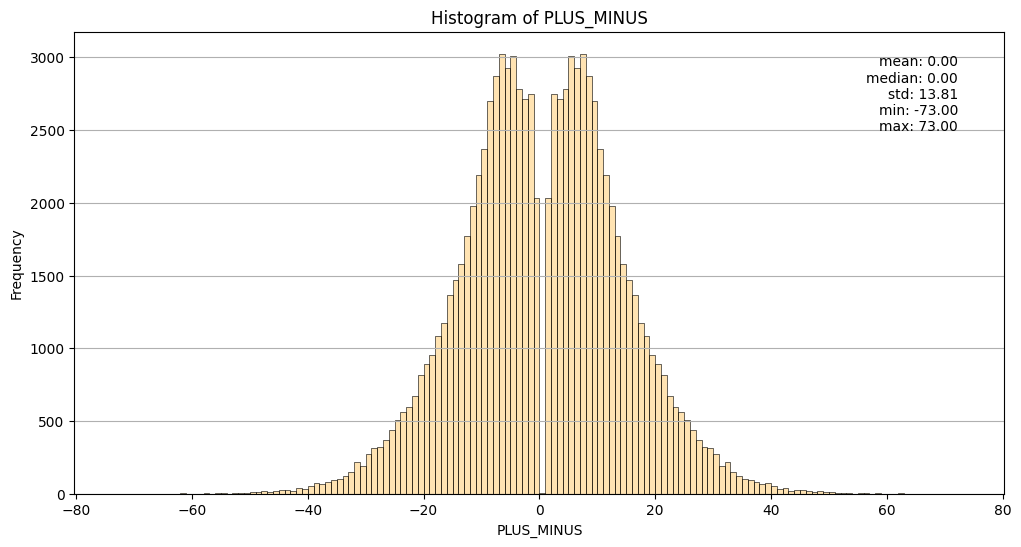

In [ ]:
generate_hist_plot(game_data, 'PLUS_MINUS', color='orange', include_stats=True)

Confirming that a plus-minus of 0 is impossible, no 0's are recorded. However, it can also be seen that there are (what might be) lower-than-expected surrounding values of 0! This is clearly the case with a plus-minus of -1 or 1. This interference-pattern-looking distribution is interesting, and perhaps something to keep an eye on.

As a final visualization of plus-minus's distribution, the following cell gives a 3D visualization of the final score of a game!

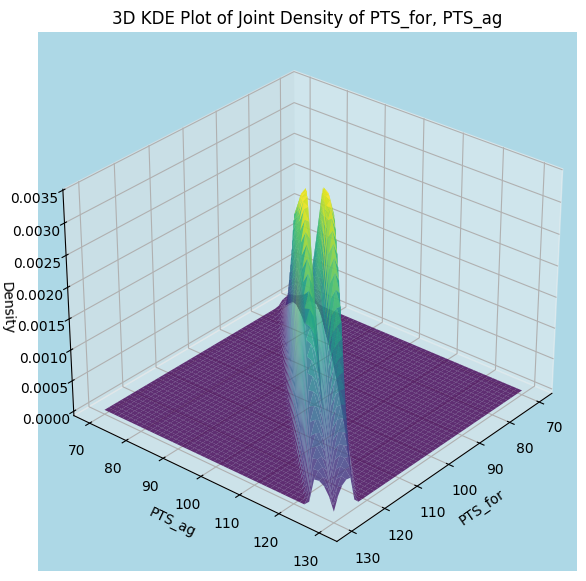

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

condn = (abs(cleaned_games['PLUS_MINUS_for']) <= 5)

x = cleaned_games.loc[condn,'PTS_for']
y = cleaned_games.loc[condn, 'PTS_ag']

kde = gaussian_kde(np.vstack([x, y]))

# Create a grid of points
x_grid = np.linspace(min(x) - 1, max(x) + 1, 30)
y_grid = np.linspace(min(y) - 1, max(y) + 1, 30)
x_grid = np.linspace(70, 130)
y_grid = np.linspace(70, 130)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

# Evaluate the KDE on the grid
z_mesh = kde(np.vstack([x_mesh.ravel(), y_mesh.ravel()]))
z_mesh = z_mesh.reshape(x_mesh.shape)

# Create the 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_mesh, y_mesh, z_mesh, cmap='viridis', alpha=0.8)

# Set the view angle to look along the x=y line
ax.view_init(elev=30, azim=40)  # Adjust these angles as needed

# Labels and title
ax.set_xlabel('PTS_for')
ax.set_ylabel('PTS_ag')
ax.set_zlabel('Density')
ax.set_title('3D KDE Plot of Joint Density of PTS_for, PTS_ag')

# Change background color
ax.set_facecolor('lightblue')
plt.show()

How to interpret the plot above? Locate a value for 'PTS_for' (e.g. 110), a value for 'PTS_ag' (e.g. 115), and the height of the graph helps us visualize how common that score was, relative to all recorded scores!

 The part in the plot occurs where points for and points against are (theoretically) equal, and it is seen that a rise in density as score deviates from this part. The two occur where the difference in score is most likely.

 *NOTE: for visual clarity in the part, the plot is cut for values where the difference between PTS_for and PTS_ag were greater than 5.*

This motivates the question: are there other multivariate relationships in the data? This is explored more generally in the next section.

## (3.2) Visualizing and Analyzing Correlations

This section focuses on explroing and identifying how stats from the same game may be related to one another.

But first, a quality of the data must be addressed: *distribution shift*. From a probability and statistics framework: sampled data exists on a *true distribution*, which can be inconceivably complex, and this framework can be extended to the NBA stats/data being considered. It is more than likely that due to a variety of reasons/variates that aren't being considered (e.g. changes in strategy, rule changes, etc.), the distribution can shift in a way that can't be easily identified/isolated, and interfere with the analysis of other variates. When trying to identify general relationships of data with respect to each game, this can pose an issue.

Distribution shift can't entirely be accounted for in practice. However, with NBA data, it can be expected that this distribution shift is more severe from season to season. Thus to mitigate influence coming from these varying distributions, **it makes sense to simply standardize each entry of a given column by the mean and standard deviation of the stat in its given season**, especially considering that most of our distributions are normal. The utility function *get_normalized_by_season* was written specifically for this functionality, and is used below:

*NOTE: Much done in this notebook beyond this point uses the normalized data for the reasons described above, and for better clarity*

In [ ]:
from src.data.processing import (
    get_normalized_by_season
)

normalized_game_data, _ = get_normalized_by_season(
    game_data=game_data,
    game_metadata=game_metadata,
)
check_df(normalized_game_data)
normalized_game_data.head()

 --- DATATYPES --- 
UNIQUE_ID           int64
MIN_for           float64
PTS_for           float64
FGM_for           float64
FGA_for           float64
FG3M_for          float64
FG3A_for          float64
FTM_for           float64
FTA_for           float64
OREB_for          float64
DREB_for          float64
REB_for           float64
AST_for           float64
STL_for           float64
BLK_for           float64
TOV_for           float64
PF_for            float64
PLUS_MINUS_for    float64
IS_HOME_for       float64
MIN_ag            float64
PTS_ag            float64
FGM_ag            float64
FGA_ag            float64
FG3M_ag           float64
FG3A_ag           float64
FTM_ag            float64
FTA_ag            float64
OREB_ag           float64
DREB_ag           float64
REB_ag            float64
AST_ag            float64
STL_ag            float64
BLK_ag            float64
TOV_ag            float64
PF_ag             float64
PLUS_MINUS_ag     float64
IS_HOME_ag        float64
dtype: object

 --

,UNIQUE_ID,MIN_for,PTS_for,FGM_for,FGA_for,FG3M_for,FG3A_for,FTM_for,FTA_for,OREB_for,...,OREB_ag,DREB_ag,REB_ag,AST_ag,STL_ag,BLK_ag,TOV_ag,PF_ag,PLUS_MINUS_ag,IS_HOME_ag
0,200000010,-0.259500,0.538679,0.465563,-1.923170,-0.711116,-1.151070,0.545196,0.656126,-0.979527,...,0.492394,-1.422735,-0.835166,-1.531403,-0.618025,-0.449939,1.902968,1.666644,-2.237180,0.99979
1,200000011,-0.509485,-1.985160,-2.151718,-1.396232,-0.711116,-0.546065,0.065671,-0.111030,0.492394,...,-0.979527,-0.280705,-0.835166,1.028443,0.739005,-0.092453,-0.350397,0.359853,2.237180,-0.99979
2,200000020,-0.259500,-0.766755,-0.742412,-0.342355,-1.096317,-1.352738,0.225513,0.911845,-0.243566,...,0.001754,0.861325,0.692310,0.437709,0.399747,0.980004,-0.600771,1.884443,-0.308577,0.99979
3,200000021,-0.384493,-1.114870,-0.943742,0.579787,-0.711116,-0.747733,-0.254012,0.144689,0.001754,...,-0.243566,2.003355,1.456048,-1.137581,-0.957282,0.980004,1.151846,1.013249,0.308577,-0.99979
4,200000030,-0.134507,-0.766755,-0.541083,-1.132762,-0.325915,-1.352738,-0.413854,-0.111030,-0.734207,...,-0.979527,-0.280705,-0.835166,-0.349936,0.739005,1.337490,0.150351,0.359853,0.848586,0.99979


Now working with normalized data, relationships in the data with respect to each game may be more evident. Let's generate correlation matrices and plot them, using the utility function *generate_corr_matrices* below.

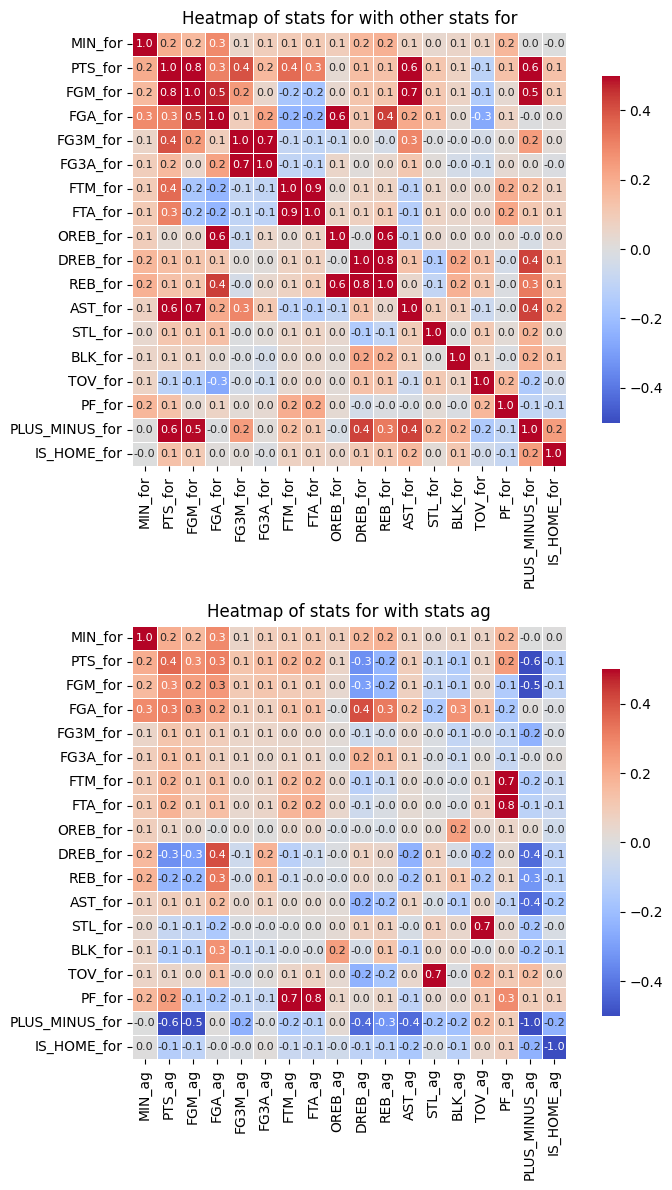

In [ ]:
from src.data.visualization import (
    generate_corr_matrices
)

generate_corr_matrices(normalized_game_data)

As can be seen above, two separate correlation maps are generated: one to visualize the correlations of 'stats for' with each other, and another to visualize the corrleations of 'stats for' with 'stats against'. The more red, the more positive the correlation between two stats; the more blue, the more negative.

Specifically, the first correlation matrix shows how well a stat a given team records in a game correlates with other given stats a team records that game. Whereas the second correlation matrix shows how well a stat a given team records in a game correlates with stats the *opposing* team records that game.

Digging a bit deeper, let's look into the first correlation matrix. It can be seen that stats a team records during a game *generally* seem to be positively correlated with one another, **but there are many exceptions** and this clearly is not a rule.

Now let's look into the second correlation matrix. While many of the stats a team accumulates track negatively with the stats a the opposing team accumulates during the game, it can be seen that some mirrored stats, e.g. 'PTS_for' and 'PTS_ag', actually track with one another! In other words, if one team in a game scores many points, the opposing team is likely to as well. Recall that there is no bias from the game changing over time, due to normalizing data, so these are meaningful results (ASIDE: this could be due to PACE, a stat to be incorporated into this project down the line. PACE measures how many posessions teams have throughout the game, which influences how many points they score).

There is a lot more worth noting and to be uncovered. But overall, what can be taken away from these results is that there may be/are some complex relationships between stats recorded during a game. Afterall, if there were no correlations, that might imply that all of these stats are independent of one another, including plus-minus/game outcome, and that doesn't make much sense!

As a final note, since heat maps are generated with stats that occur *during* a given game, while they may be insightful, they can't be explicitly used for the purpose of predicting the outcome of a game that has yet to be played. However, they *do* suggest that there is a good way to think through these stats in relation to one another, and thus predict how a game can/will play out.

## (3.3) Looking into Relationships Between Different Games using Rolling Averages

In the previous few sections, how stats with respect to a given game relate to themselves was analyzed. For instance, for game $X$, we looked at stats in game $X$ relate to other stats in game $X$. But now, let's shift focus more towards our main objective: **figuring out what can be predictive the outcome of a game that has yet to be played**. How do stats from game $X$ relate to stats from game $Y$, and can these be leveraged to make predictions?

The utility function *get_rolling_avgs* was written to get the rolling average of team's stats going into games given window sizes (wrt season). A rolling average of a stat is an average of its value over a previous amount of games. The calculated rolling averages do **not** include the stats of the game the rolling average is being calculated with respect to; in other words, the rolling averages **don't look ahead**.

Specifically: if k is the window size, then with respect to any given stat (e.g. PTS), 4 rolling averages are taken:
 * 'STAT_for_prev_k': The stat accumulated by the team whose perspective the row is from.
 * 'STAT_ag_prev_k': The stat accumulated against the team whose perspective the row is from.
 * 'STAT_for_opp_prev_k': The stat accumulated by the team opposing the team whose persepective the row is from.
 * 'STAT_ag_opp_prev_k': The stat accumulated against the team opposing the team whose perspective the row is from.

These rolling averages can give a solid picture of both teams' offensive and defensive stats going into a game. The following few cells demonstrate this functionality with a rolling average of 1, and illustrate exactly what these rolling averages are.

In [ ]:
from src.data.processing import (
    get_rolling_avgs
)

prev_1_game_data = get_rolling_avgs(
    game_data=game_data,
    game_metadata=game_metadata,
    windows=[1]
)
check_df(prev_1_game_data)
prev_1_game_data.head()

 --- DATATYPES --- 
MIN_for_prev_1               float64
PTS_for_prev_1               float64
FGM_for_prev_1               float64
FGA_for_prev_1               float64
FG3M_for_prev_1              float64
                              ...   
BLK_for_opp_prev_1           float64
TOV_for_opp_prev_1           float64
PF_for_opp_prev_1            float64
PLUS_MINUS_for_opp_prev_1    float64
IS_HOME_for_opp_prev_1       float64
Length: 73, dtype: object

 --- SHAPE --- 
95756 rows, 73 columns 

 --- NaN's PER COLUMN --- 
No NaN's found


,MIN_for_prev_1,PTS_for_prev_1,FGM_for_prev_1,FGA_for_prev_1,FG3M_for_prev_1,FG3A_for_prev_1,FTM_for_prev_1,FTA_for_prev_1,OREB_for_prev_1,DREB_for_prev_1,...,OREB_for_opp_prev_1,DREB_for_opp_prev_1,REB_for_opp_prev_1,AST_for_opp_prev_1,STL_for_opp_prev_1,BLK_for_opp_prev_1,TOV_for_opp_prev_1,PF_for_opp_prev_1,PLUS_MINUS_for_opp_prev_1,IS_HOME_for_opp_prev_1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,240.0,108.0,41.0,90.0,0.0,0.0,26.0,38.0,15.0,18.0,...,17.0,27.0,44.0,26.0,8.0,7.0,12.0,33.0,6.0,1.0
2,240.0,117.0,49.0,94.0,0.0,1.0,19.0,30.0,27.0,21.0,...,15.0,35.0,50.0,21.0,8.0,3.0,23.0,32.0,-3.0,0.0
3,240.0,95.0,38.0,81.0,0.0,0.0,19.0,30.0,12.0,29.0,...,14.0,25.0,39.0,14.0,10.0,4.0,21.0,31.0,-5.0,0.0
4,240.0,103.0,42.0,86.0,1.0,1.0,18.0,26.0,19.0,27.0,...,11.0,21.0,32.0,26.0,7.0,5.0,8.0,21.0,10.0,0.0


Using these rolling averages with window size 1, the following cell shows how they relate to the rows they are calculated with respect to:

In [ ]:
cols = ['SEASON_ID', 'TEAM_ABBREVIATION_for', 'GAME_DATE', 'PTS_for', 'PTS_ag', 'PTS_for_prev_1', 'PTS_ag_prev_1']
pd.merge(cleaned_games, prev_1_game_data, on='UNIQUE_ID').sort_values(by=['SEASON_ID', 'NEW_TEAM_ID_for', 'GAME_DATE']).loc[:, cols].head(6)

,SEASON_ID,TEAM_ABBREVIATION_for,GAME_DATE,PTS_for,PTS_ag,PTS_for_prev_1,PTS_ag_prev_1
8,21983,ATL,1983-10-28,108,126,0.0,0.0
27,21983,ATL,1983-10-29,117,115,108.0,126.0
53,21983,ATL,1983-11-01,95,92,117.0,115.0
81,21983,ATL,1983-11-04,103,90,95.0,92.0
114,21983,ATL,1983-11-06,84,97,103.0,90.0
118,21983,ATL,1983-11-08,90,97,84.0,97.0


First, note that the suffix '_for' denotes stats recorded for the team whose perspective the row is from.

Now, as can be seen above, 'PTS_for_prev_1' is the 'PTS_for' recorded by the team whose perspective the row is from in the previous game. Similarly, 'PTS_ag_prev_1' is the 'PTS_ag' recorded by the team whose perspective the row is from in the previous game.

Now let's look at the opposing rolling average stats:

In [ ]:
cols = ['SEASON_ID', 'TEAM_ABBREVIATION_ag', 'GAME_DATE', 'PTS_for', 'PTS_ag', 'PTS_for_opp_prev_1', 'PTS_ag_opp_prev_1']
pd.merge(cleaned_games, prev_1_game_data, on='UNIQUE_ID').sort_values(by=['SEASON_ID', 'NEW_TEAM_ID_ag', 'GAME_DATE']).loc[:, cols].head(6)

,SEASON_ID,TEAM_ABBREVIATION_ag,GAME_DATE,PTS_for,PTS_ag,PTS_for_opp_prev_1,PTS_ag_opp_prev_1
9,21983,ATL,1983-10-28,126,108,0.0,0.0
26,21983,ATL,1983-10-29,115,117,108.0,126.0
52,21983,ATL,1983-11-01,92,95,117.0,115.0
80,21983,ATL,1983-11-04,90,103,95.0,92.0
115,21983,ATL,1983-11-06,97,84,103.0,90.0
119,21983,ATL,1983-11-08,97,90,84.0,97.0


Now, note that the suffiz '_ag' denotes stats recorded for the team *opposing* the team whose perspective the row is from.

As can be seen above, 'PTS_for_opp_prev_1' is the 'PTS_for' recorded by the team *opposing* the team whose perspective the row is from, in the previous game. Similarly, 'PTS_ag_opp_prev_1' is the 'PTS_ag' recorded by the team *opposing* the team whose perspective the row is from, in the previous game.

Now it is sorted out what each rolling average stat refers to. Again note that these are stats previously recorded with respect to a game, and **thus can be used to predict the game's outcome beforehand**. The following cell calculates the correlations of these rolling averages of previous stats going into a game, and the outcome of the game (point differential, i.e. plus-minus):

*NOTE: the home team is known going into a game, so these have been included into the correlations!*

In [ ]:
prev_1_stats = [col for col in list(prev_1_game_data.columns) if col != 'UNIQUE_ID']
corr_mx = pd.merge(game_data, prev_1_game_data, on='UNIQUE_ID')[['PLUS_MINUS_for', 'IS_HOME_for', 'IS_HOME_ag'] + prev_1_stats].corr()
corr_mx['PLUS_MINUS_for'].sort_values(ascending=False)

,PLUS_MINUS_for
PLUS_MINUS_for,1.000000
IS_HOME_for,0.236436
PLUS_MINUS_for_prev_1,0.111150
PLUS_MINUS_ag_opp_prev_1,0.111150
AST_ag_opp_prev_1,0.048329
...,...
PTS_ag_prev_1,-0.046579
AST_ag_prev_1,-0.048329
PLUS_MINUS_for_opp_prev_1,-0.111150
PLUS_MINUS_ag_prev_1,-0.111150


As can be seen above, some of these previous stats are correlated with game outcome, and thus could potentially be good indicators for it. Notably, 'IS_HOME' stats have the highest correlations, whereas 'PLUS_MINUS' rolling averages are a distant second. The rest of the stats trail behind.

However, the above correlations *only* look at rolling averages over the previous '1' games. The rolling averages function is far more powerful than this, and can calculate rolling averages for any range of window sizes, including a window size of '0', which looks back at *all* relevant games that season played that season. The following cell briefly illustrates this:

In [ ]:
prev_0_game_data = get_rolling_avgs(
    game_data=game_data,
    game_metadata=game_metadata,
    windows=[0]
)

cols = ['SEASON_ID', 'TEAM_ABBREVIATION_for', 'GAME_DATE', 'PTS_for', 'PTS_ag', 'PTS_for_prev_0', 'PTS_ag_prev_0']
pd.merge(cleaned_games, prev_0_game_data, on='UNIQUE_ID').sort_values(by=['SEASON_ID', 'NEW_TEAM_ID_for', 'GAME_DATE']).loc[:, cols].head(6)

,SEASON_ID,TEAM_ABBREVIATION_for,GAME_DATE,PTS_for,PTS_ag,PTS_for_prev_0,PTS_ag_prev_0
8,21983,ATL,1983-10-28,108,126,0.000000,0.00
27,21983,ATL,1983-10-29,117,115,108.000000,126.00
53,21983,ATL,1983-11-01,95,92,112.500000,120.50
81,21983,ATL,1983-11-04,103,90,106.666667,111.00
114,21983,ATL,1983-11-06,84,97,105.750000,105.75
118,21983,ATL,1983-11-08,90,97,101.400000,104.00


Rolling averages with the smallest possible window size were already proven to be correlated with game outcome, so the question arises: is this the same with other window sizes? Furthermore, is there an optimal window size to look back over to get stats more correlated with game outcome?

The following utility functions leverage the power of our rolling averages function to plot correlations of stats to game outcome ('PLUS_MINUS_for') over previous window sizes. The first function, *calculate_corrs_for_windows*, calculates rolling averages for window sizes that are powers of 2, up until the window size is the entire season, and correlates this with game outcome. The second function, *plot_corrs_for_windows*,  visualizes these results and allows for better analysis:

*NOTE: if the specified lookback window exceeds the number of games previously played to calculate a rolling average from, then all previous games available will be used*

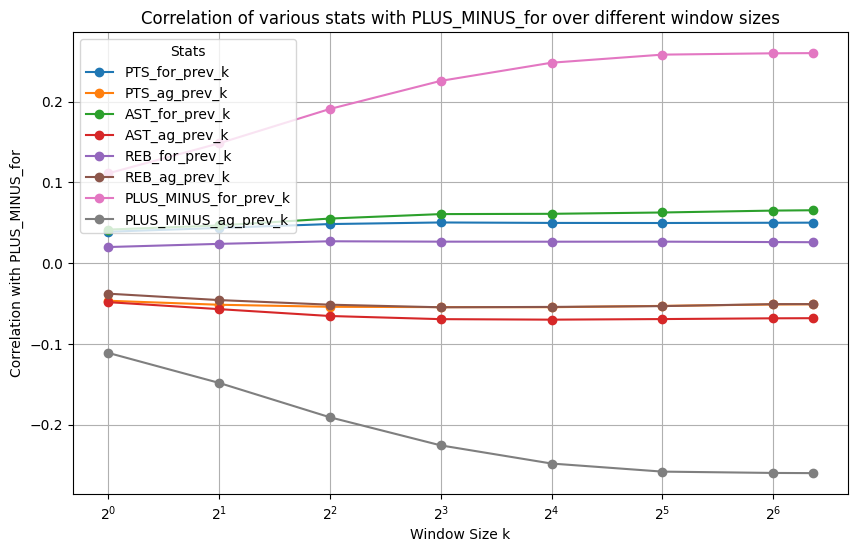

In [ ]:
from src.data.visualization import (
    calculate_corrs_for_windows,
    plot_corrs_for_windows
)

stats_to_analyze = [
    'PTS_for', 'PTS_ag',
    'AST_for', 'AST_ag',
    'REB_for', 'REB_ag',
    'PLUS_MINUS_for', 'PLUS_MINUS_ag'
]  # Replace with actual stat column names
window_sizes, results = calculate_corrs_for_windows(game_data, game_metadata, stats_to_analyze)
plot_corrs_for_windows(window_sizes, results)

The lookback window sizes used were k=[1, 2, 4, 8, 16, 32, 64, 82]. As can be seen above, the correlation that of the rolling stats have with game outcome are increasing with window size. This is especially the case with rolling averages of 'PLUS_MINUS', whose correlation with game outcome, i.e. 'PLUS_MINUS' of the game in question, exceeds home team advantage.

Below, the correlations with 'prev_0' stats specifically are calculated, akin to how they were above with 'prev_1' stats.

In [ ]:
prev_0_stats = [col for col in list(prev_0_game_data.columns) if col != 'UNIQUE_ID']
corr_mx = pd.merge(game_data, prev_0_game_data, on='UNIQUE_ID')[['PLUS_MINUS_for', 'IS_HOME_for', 'IS_HOME_ag'] + prev_0_stats].corr()
corr_mx['PLUS_MINUS_for'].sort_values(ascending=False)

,PLUS_MINUS_for
PLUS_MINUS_for,1.000000
PLUS_MINUS_for_prev_0,0.260002
PLUS_MINUS_ag_opp_prev_0,0.260002
IS_HOME_for,0.236436
BLK_ag_opp_prev_0,0.106166
...,...
AST_ag_prev_0,-0.068182
BLK_ag_prev_0,-0.106166
IS_HOME_ag,-0.236436
PLUS_MINUS_for_opp_prev_0,-0.260002


These numbers confirm that the 'prev_0' correlations have far more weight behind them than the 'prev_1' stats, which is not a surprise from the plot showing how they change over time. Now, with a better idea of what data/stats may be useful to predicting game outcomes, this insight is leveraged to build models to predict game outcomes in following sections.

Using what was learned from this section, the following script was written in order to save features into our database that will be useful for predicting game outcome.


In [ ]:
# Makes 'prev_0' roling features by default
run_script("scripts/make_rolling_features.py")

# Check DB
run_script("scripts/check_db.py")

 * Table saved to 'data/clean/cleaned_data.db' as 'game_data_norm_prev_0' (run 'python scripts/check_db.py' for more info)
--- CHECKING DATABASE ---

TABLE: game_metadata
 * 95764 rows, 11 columns
 - - UNIQUE_ID (INTEGER)
 - - SEASON_ID (INTEGER)
 - - IS_HOME (INTEGER)
 - - GAME_ID (TEXT)
 - - GAME_DATE (TEXT)
 - - MATCHUP (TEXT)
 - - WL (TEXT)
 - - TEAM_ABBREVIATION_for (TEXT)
 - - NEW_TEAM_ID_for (INTEGER)
 - - NEW_TEAM_ID_ag (INTEGER)
 - - TEAM_ABBREVIATION_ag (TEXT)

TABLE: team_metadata
 * 1193 rows, 5 columns
 - - SEASON_ID (INTEGER)
 - - TEAM_ID (INTEGER)
 - - TEAM_ABBREVIATION (TEXT)
 - - TEAM_NAME (TEXT)
 - - NEW_TEAM_ID (INTEGER)

TABLE: game_data
 * 95756 rows, 37 columns
 - - MIN_for (INTEGER)
 - - PTS_for (INTEGER)
 - - FGM_for (INTEGER)
 - - FGA_for (INTEGER)
 - - FG3M_for (INTEGER)
 - - FG3A_for (REAL)
 - - FTM_for (INTEGER)
 - - FTA_for (INTEGER)
 - - OREB_for (REAL)
 - - DREB_for (REAL)
 - - REB_for (REAL)
 - - AST_for (INTEGER)
 - - STL_for (REAL)
 - - BLK_for (INTEGE

# (4) Using Machine Learning/Statistical Modeling to Predict Game Outcome
Packages used include:
```
# pandas, matplotlib + seaborn, numpy, sklearn
```

## (4.1) Defining Problem Setup, a Train-Val-Test Split, and a Proper Baseline

 * Will be explicitly evaluated as a regression task based on game score
 * Also evaluated as binary classification based on win-loss as well.
 * Evaluating as regression is simplified setup; ideally should be multiclass; was done in order to have models understand how much a game was won by

For the all of the modeling sections, all results (as they come through) will be stored in the following dictionary-based class, named *Results*, containing metrics from all experiments. This class will be used to display a table of the results at the end of relevant sections.

In [ ]:
import optuna
import optuna.visualization as vis
from src.utils import get_metric_quantiles_fig

In [ ]:
run_script("scripts/tune_model.py", {"--modeling_config" : "baseline_0.py"})

[I 2025-10-07 13:15:50,681] A new study created in RDB with name: baseline_0_study

 * Tuning on split 1 (val_season=2020, n_train_seasons=1 -> training from 2019+)...
 -> Val Season: 2020
 -> MAE: 0.801
 -> RMSE: 1.000
 -> R^2 Score: 0.000
 -> Accuracy: 0.500
 -> ROC AUC Score: 0.500
 -> Time to fit: 0.009265 seconds

 * Tuning on split 2 (val_season=2021, n_train_seasons=1 -> training from 2020+)...
 -> Val Season: 2021
 -> MAE: 0.803
 -> RMSE: 1.000
 -> R^2 Score: 0.000
 -> Accuracy: 0.500
 -> ROC AUC Score: 0.500
 -> Time to fit: 0.005949 seconds

 * Tuning on split 3 (val_season=2022, n_train_seasons=1 -> training from 2021+)...
 -> Val Season: 2022
 -> MAE: 0.805
 -> RMSE: 1.000
 -> R^2 Score: 0.000
 -> Accuracy: 0.500
 -> ROC AUC Score: 0.500
 -> Time to fit: 0.005805 seconds

 * Tuning on split 4 (val_season=2023, n_train_seasons=1 -> training from 2022+)...
 -> Val Season: 2023
 -> MAE: 0.797
 -> RMSE: 1.000
 -> R^2 Score: 0.000
 -> Accuracy: 0.500
 -> ROC AUC Score: 0.500
 ->

In [ ]:
run_script("scripts/tune_model.py", {"--modeling_config" : "baseline_1.py", "--n_trials" : "10"})

[I 2025-10-07 13:16:02,980] A new study created in RDB with name: baseline_1_study

 * Tuning on split 1 (val_season=2020, n_train_seasons=1 -> training from 2019+)...
 -> Val Season: 2020
 -> MAE: 0.955
 -> RMSE: 1.211
 -> R^2 Score: -0.468
 -> Accuracy: 0.544
 -> ROC AUC Score: 0.544
 -> Time to fit: 0.006628 seconds

 * Tuning on split 2 (val_season=2021, n_train_seasons=1 -> training from 2020+)...
 -> Val Season: 2021
 -> MAE: 0.936
 -> RMSE: 1.180
 -> R^2 Score: -0.394
 -> Accuracy: 0.544
 -> ROC AUC Score: 0.544
 -> Time to fit: 0.005644 seconds

 * Tuning on split 3 (val_season=2022, n_train_seasons=1 -> training from 2021+)...
 -> Val Season: 2022
 -> MAE: 0.890
 -> RMSE: 1.136
 -> R^2 Score: -0.292
 -> Accuracy: 0.580
 -> ROC AUC Score: 0.580
 -> Time to fit: 0.005373 seconds

 * Tuning on split 4 (val_season=2023, n_train_seasons=1 -> training from 2022+)...
 -> Val Season: 2023
 -> MAE: 0.945
 -> RMSE: 1.165
 -> R^2 Score: -0.358
 -> Accuracy: 0.543
 -> ROC AUC Score: 0.543

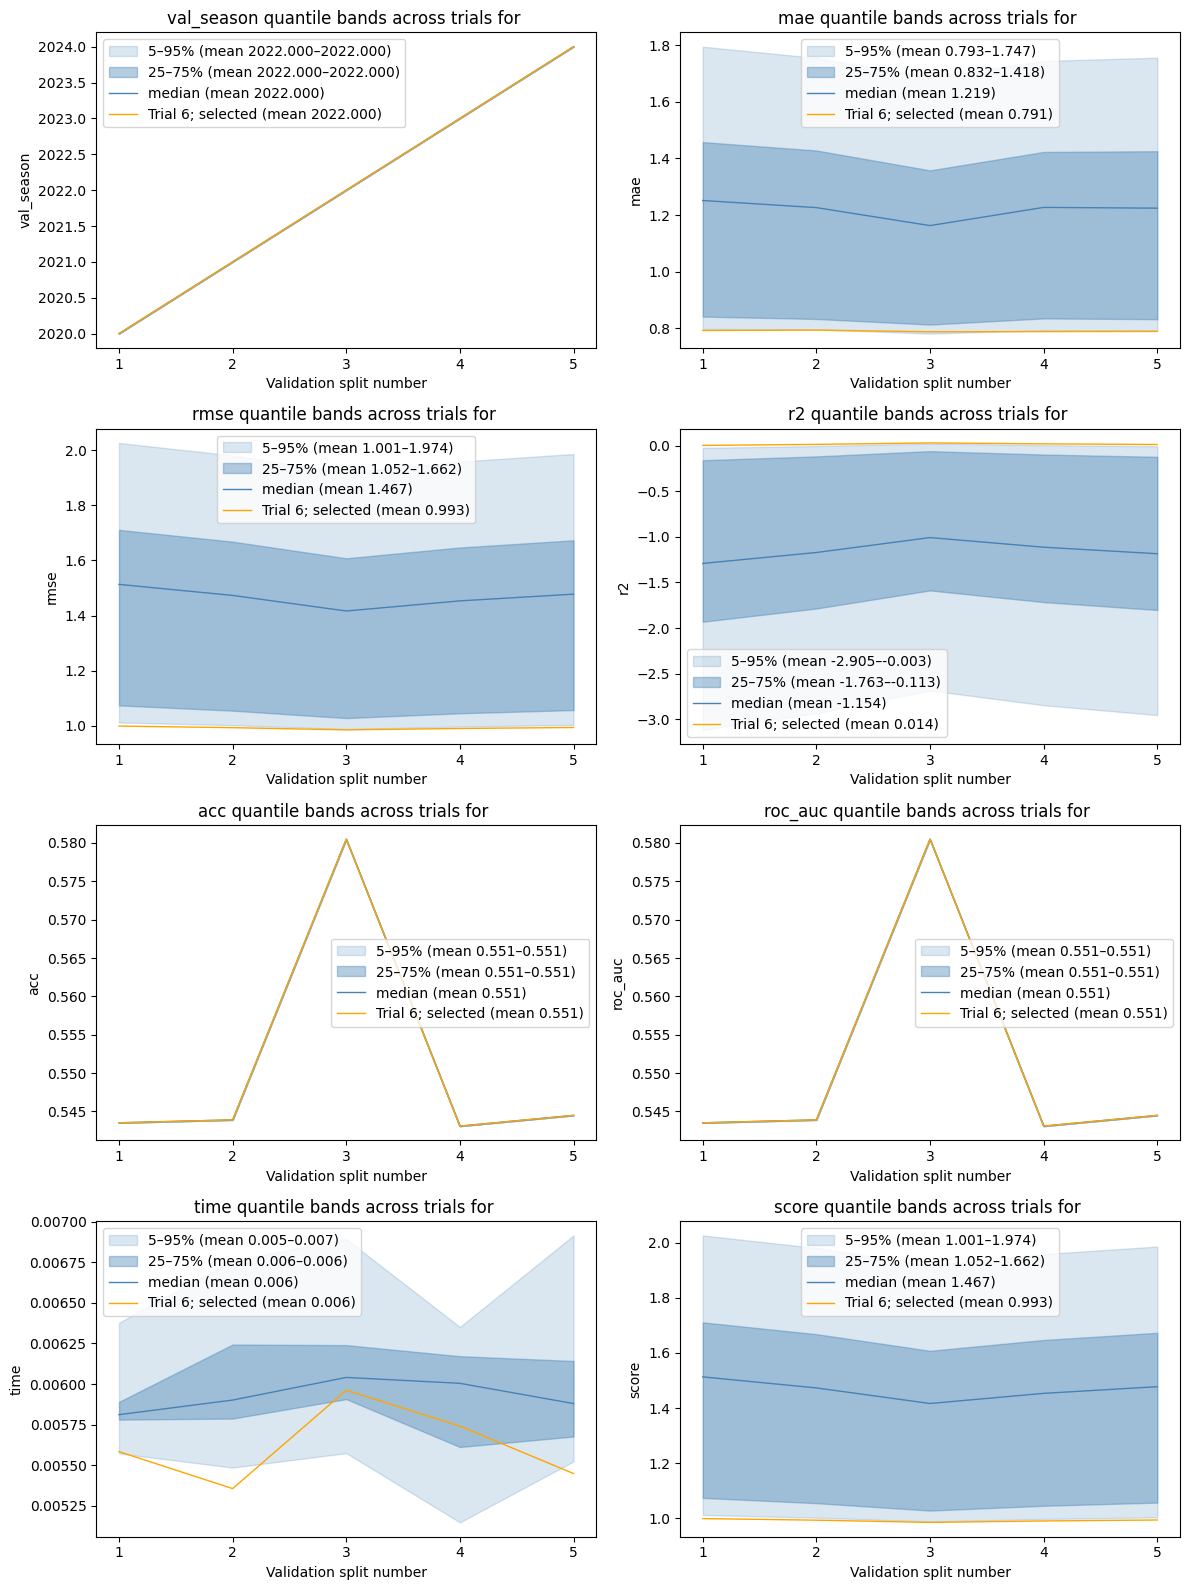

In [ ]:
# Load study into memory
baseline_1_study = optuna.load_study(
    study_name="baseline_1_study",
    storage="sqlite:///optuna_studies.db"
)

# Visualize the study
vis.plot_optimization_history(baseline_1_study).show()
vis.plot_parallel_coordinate(baseline_1_study).show()
vis.plot_param_importances(baseline_1_study).show()
vis.plot_slice(baseline_1_study).show()

get_metric_quantiles_fig(baseline_1_study).show()

In [ ]:
# For loading in optuna_studies.db
if CONTROL_FLOW['load_studies']:
    source_file = Path(STORAGE_PATH) / config['optuna_storage'].replace("sqlite:///", "")
    dest_file = Path(config['optuna_storage'].replace("sqlite:///", ""))
    if source_file.exists():
        # Make sure the destination folder exists
        dest_file.parent.mkdir(parents=True, exist_ok=True)

        # Copy the file
        shutil.copy2(source_file, dest_file)
        print(f"Copied {source_file} to {dest_file}")
    else:
        print("Data to load not found")
else:
    print("Optuna studies database not loaded")

Copied /content/drive/My Drive/Programming Projects/NBA Modeling Demo/optuna_studies.db to optuna_studies.db


In [ ]:
!ls

app.py	     environment.yml   optuna_studies.db  scripts
config.yaml  modeling_configs  README.md	  src
data	     models	       requirements.txt


In [ ]:
# For tuning lasso
if CONTROL_FLOW['tune_models']:

    kwargs = {
        "--modeling_config" : "lasso.py",
        "--n_trials" : f"{N_TUNING_TRIALS['lasso']}"
    }
    run_script("scripts/tune_model.py", kwargs)

if CONTROL_FLOW['save_studies']:
    source_file = Path(config["optuna_storage"].replace("sqlite:///", ""))
    dest_file = Path(STORAGE_PATH) / config['optuna_storage'].replace("sqlite:///", "")
    if source_file.exists():
        # Make sure the destination folder exists
        dest_file.parent.mkdir(parents=True, exist_ok=True)

        # Copy the file
        shutil.copy2(source_file, dest_file)
        print(f"Copied {source_file} to {dest_file}")
    else:
        print("Data to load not found")


[I 2025-10-07 13:16:19,357] Using an existing study with name 'lasso_study' instead of creating a new one.

Best Trial:

FrozenTrial(number=20, state=1, values=[0.9336771092939316], datetime_start=datetime.datetime(2025, 10, 6, 20, 55, 21, 879388), datetime_complete=datetime.datetime(2025, 10, 6, 20, 55, 22, 214696), params={'alpha': 0.00300960366932627, 'n_train_seasons': 4}, user_attrs={'metrics': {'val_season': [2020, 2021, 2022, 2023, 2024], 'mae': [0.7521090356299104, 0.7525490577023299, 0.7436515179208116, 0.7145846137265548, 0.7063202353715627], 'rmse': [0.9556740221880596, 0.953528162273041, 0.9449048690200821, 0.9111961669197947, 0.9030823260686801], 'r2': [0.08626413745260553, 0.09041429346498775, 0.10679169569551361, 0.16938389656814046, 0.18410929572839374], 'acc': [0.6148148148148148, 0.6227642276422765, 0.6199186991869918, 0.6373983739837399, 0.6489795918367347], 'roc_auc': [0.6596913580246913, 0.6575821270407827, 0.668112895763104, 0.7079264987771828, 0.7138518950437318]

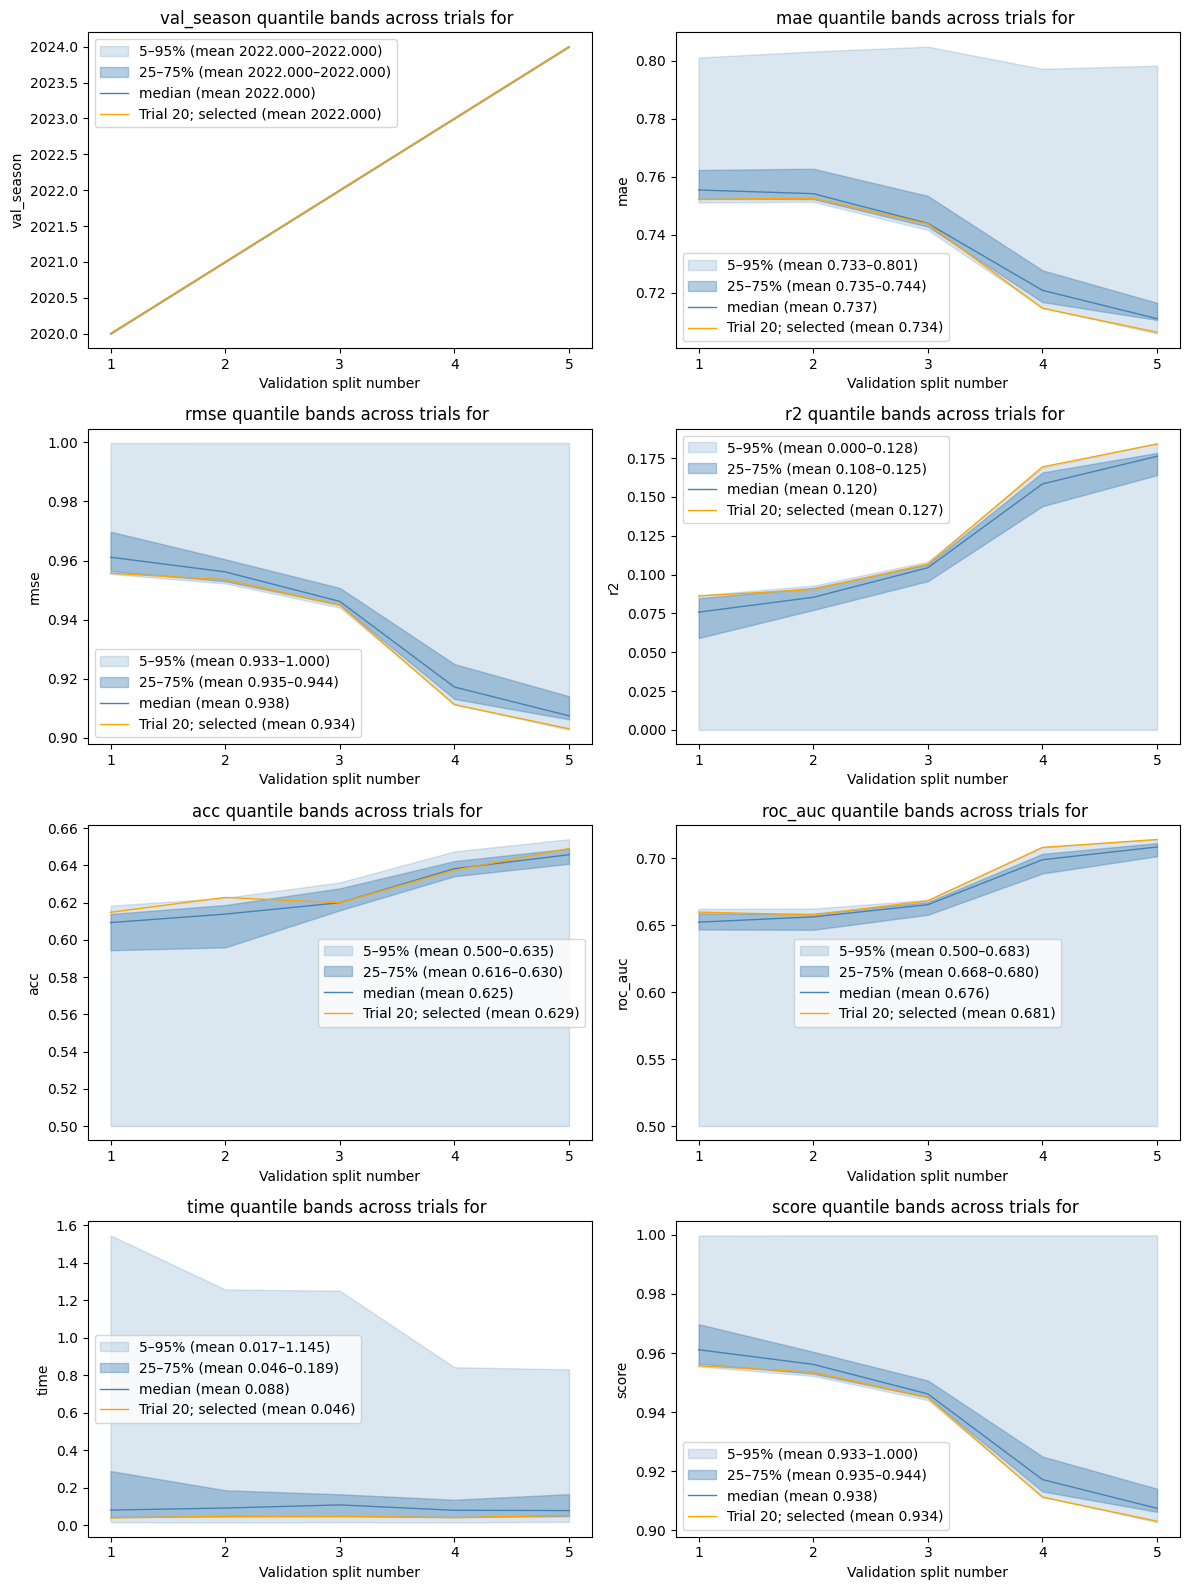

In [ ]:
# Load study into memory
lasso_study = optuna.load_study(
    study_name="lasso_study",
    storage=config['optuna_storage']
)

# Visualize the study
vis.plot_optimization_history(lasso_study).show()
vis.plot_parallel_coordinate(lasso_study).show()
vis.plot_param_importances(lasso_study).show()
vis.plot_slice(lasso_study).show()

get_metric_quantiles_fig(lasso_study).show()

In [ ]:
if CONTROL_FLOW['train_models']:
    modeling_config = "lasso.py"
    model_filename = "lasso_model.joblib"

    # Train the tuned lasso model, save
    kwargs = {"--modeling_config" : modeling_config}
    run_script("scripts/train_model.py", kwargs)

if CONTROL_FLOW['save_models']:

    source_file = Path(config["model_storage"]) / model_filename
    dest_file = Path(STORAGE_PATH) / config['model_storage'] / model_filename
    print(source_file)
    print(dest_file)
    if source_file.exists():
        # Make sure the destination folder exists
        dest_file.parent.mkdir(parents=True, exist_ok=True)

        # Copy the file
        shutil.copy2(source_file, dest_file)
        print(f"Copied {source_file} to {dest_file}")
    else:
        print("Data to load not found")


Best hyperparams of '<class 'sklearn.linear_model._coordinate_descent.Lasso'>' from 'lasso_study':
FrozenTrial(number=20, state=1, values=[0.9336771092939316], datetime_start=datetime.datetime(2025, 10, 6, 20, 55, 21, 879388), datetime_complete=datetime.datetime(2025, 10, 6, 20, 55, 22, 214696), params={'alpha': 0.00300960366932627, 'n_train_seasons': 4}, user_attrs={'metrics': {'val_season': [2020, 2021, 2022, 2023, 2024], 'mae': [0.7521090356299104, 0.7525490577023299, 0.7436515179208116, 0.7145846137265548, 0.7063202353715627], 'rmse': [0.9556740221880596, 0.953528162273041, 0.9449048690200821, 0.9111961669197947, 0.9030823260686801], 'r2': [0.08626413745260553, 0.09041429346498775, 0.10679169569551361, 0.16938389656814046, 0.18410929572839374], 'acc': [0.6148148148148148, 0.6227642276422765, 0.6199186991869918, 0.6373983739837399, 0.6489795918367347], 'roc_auc': [0.6596913580246913, 0.6575821270407827, 0.668112895763104, 0.7079264987771828, 0.7138518950437318], 'time': [0.039457082

In [ ]:
# For tuning lgbm
if CONTROL_FLOW['tune_models']:

    kwargs = {
        "--modeling_config" : "lgbm.py",
        "--n_trials" : f"{N_TUNING_TRIALS['lgbm']}"
    }
    run_script("scripts/tune_model.py", kwargs)

if CONTROL_FLOW['save_studies']:
    source_file = Path(config["optuna_storage"].replace("sqlite:///", ""))
    dest_file = Path(STORAGE_PATH) / config['optuna_storage'].replace("sqlite:///", "")
    print(source_file)
    print(dest_file)
    if source_file.exists():
        # Make sure the destination folder exists
        dest_file.parent.mkdir(parents=True, exist_ok=True)

        # Copy the file
        shutil.copy2(source_file, dest_file)
        print(f"Copied {source_file} to {dest_file}")
    else:
        print("Data to load not found")


[I 2025-10-07 13:16:42,784] Using an existing study with name 'lgbm_study' instead of creating a new one.

Best Trial:

FrozenTrial(number=11, state=1, values=[0.9249890308915655], datetime_start=datetime.datetime(2025, 10, 6, 20, 37, 20, 511900), datetime_complete=datetime.datetime(2025, 10, 6, 20, 38, 11, 428478), params={'n_estimators': 543, 'learning_rate': 0.0065286256093706925, 'num_leaves': 215, 'max_depth': -1, 'min_child_samples': 67, 'min_child_weight': 9.876522321735802, 'lambda_l1': 6.524739755604274, 'lambda_l2': 0.19528374527201903, 'feature_fraction': 0.6860878606088399, 'bagging_fraction': 0.503465049116142, 'bagging_freq': 10, 'n_train_seasons': 7}, user_attrs={'metrics': {'val_season': [2020, 2021, 2022, 2023, 2024], 'mae': [0.7382017640864467, 0.7379612305868046, 0.7387311215697971, 0.7128121043096873, 0.7145229603205182], 'rmse': [0.9361507782376124, 0.9336163595113115, 0.9401231005938362, 0.9115562814096868, 0.9034986347053804], 'r2': [0.1232158017948326, 0.1280060

In [ ]:
run_script("rm_study.py", {"" : "torch_ffnn_study"})

python3: can't open file '/content/NBA-Data-Modeling/rm_study.py': [Errno 2] No such file or directory


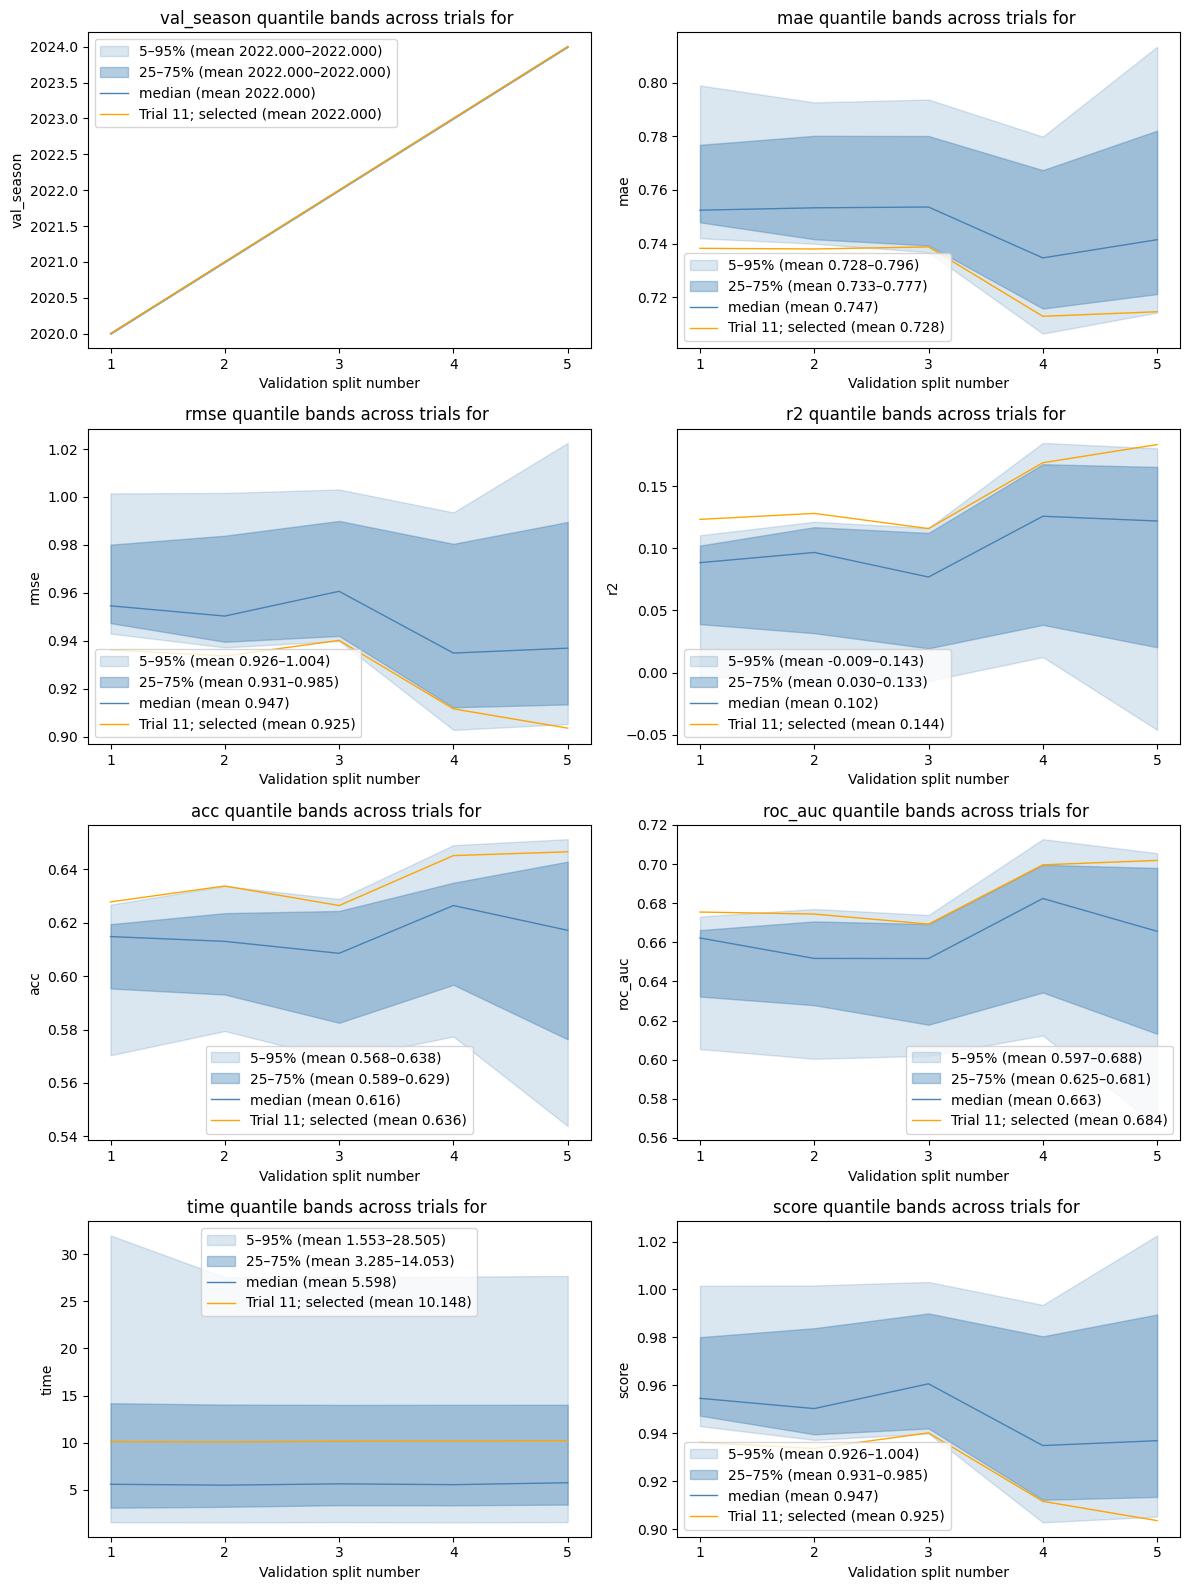

In [ ]:
# Load study into memory
lgbm_study = optuna.load_study(
    study_name="lgbm_study",
    storage="sqlite:///optuna_studies.db"
)

# Visualize the study
vis.plot_optimization_history(lgbm_study).show()
vis.plot_parallel_coordinate(lgbm_study).show()
vis.plot_param_importances(lgbm_study).show()
vis.plot_slice(lgbm_study).show()

get_metric_quantiles_fig(lgbm_study).show()

In [ ]:
# For training lgbm
if CONTROL_FLOW['train_models']:
    modeling_config = "lgbm.py"
    model_filename = "lgbm_model.joblib"

    # Train the tuned lasso model, save
    kwargs = {"--modeling_config" : modeling_config}
    run_script("scripts/train_model.py", kwargs)

if CONTROL_FLOW['save_models']:

    source_file = Path(config["model_storage"]) / model_filename
    dest_file = Path(STORAGE_PATH) / config['model_storage'] / model_filename
    print(source_file)
    print(dest_file)
    if source_file.exists():
        # Make sure the destination folder exists
        dest_file.parent.mkdir(parents=True, exist_ok=True)

        # Copy the file
        shutil.copy2(source_file, dest_file)
        print(f"Copied {source_file} to {dest_file}")
    else:
        print("Data to load not found")


Best hyperparams of '<class 'lightgbm.sklearn.LGBMRegressor'>' from 'lgbm_study':
FrozenTrial(number=11, state=1, values=[0.9249890308915655], datetime_start=datetime.datetime(2025, 10, 6, 20, 37, 20, 511900), datetime_complete=datetime.datetime(2025, 10, 6, 20, 38, 11, 428478), params={'n_estimators': 543, 'learning_rate': 0.0065286256093706925, 'num_leaves': 215, 'max_depth': -1, 'min_child_samples': 67, 'min_child_weight': 9.876522321735802, 'lambda_l1': 6.524739755604274, 'lambda_l2': 0.19528374527201903, 'feature_fraction': 0.6860878606088399, 'bagging_fraction': 0.503465049116142, 'bagging_freq': 10, 'n_train_seasons': 7}, user_attrs={'metrics': {'val_season': [2020, 2021, 2022, 2023, 2024], 'mae': [0.7382017640864467, 0.7379612305868046, 0.7387311215697971, 0.7128121043096873, 0.7145229603205182], 'rmse': [0.9361507782376124, 0.9336163595113115, 0.9401231005938362, 0.9115562814096868, 0.9034986347053804], 'r2': [0.1232158017948326, 0.12800602415697437, 0.11580912854631398, 0.168

In [ ]:
# For tuning torch_ffnn
if CONTROL_FLOW['tune_models']:

    kwargs = {
        "--modeling_config" : "torch_ffnn.py",
        "--n_trials" : f"{N_TUNING_TRIALS['torch_ffnn']}"
    }
    run_script("scripts/tune_model.py", kwargs)

if CONTROL_FLOW['save_studies']:
    source_file = Path(config["optuna_storage"].replace("sqlite:///", ""))
    dest_file = Path(STORAGE_PATH) / config['optuna_storage'].replace("sqlite:///", "")
    if source_file.exists():
        # Make sure the destination folder exists
        dest_file.parent.mkdir(parents=True, exist_ok=True)

        # Copy the file
        shutil.copy2(source_file, dest_file)
        print(f"Copied {source_file} to {dest_file}")
    else:
        print("Data to load not found")


Streaming output truncated to the last 5000 lines.
 -- Epoch 3/3 -- : 100%|██████████| 19/19 [00:20<00:00,  1.05s/it]
 -> Val Season: 2022
 -> MAE: 0.752
 -> RMSE: 0.957
 -> R^2 Score: 0.084
 -> Accuracy: 0.606
 -> ROC AUC Score: 0.650
 -> Time to fit: 61.539269 seconds

 * Tuning on split 4 (val_season=2023, n_train_seasons=8 -> training from 2015+)...

 -- Epoch 1/3 -- : 100%|██████████| 19/19 [00:19<00:00,  1.04s/it]

 -- Epoch 2/3 -- : 100%|██████████| 19/19 [00:19<00:00,  1.04s/it]

 -- Epoch 3/3 -- : 100%|██████████| 19/19 [00:19<00:00,  1.04s/it]
 -> Val Season: 2023
 -> MAE: 0.728
 -> RMSE: 0.924
 -> R^2 Score: 0.147
 -> Accuracy: 0.643
 -> ROC AUC Score: 0.690
 -> Time to fit: 61.371757 seconds

 * Tuning on split 5 (val_season=2024, n_train_seasons=8 -> training from 2016+)...

 -- Epoch 1/3 -- : 100%|██████████| 19/19 [00:19<00:00,  1.04s/it]

 -- Epoch 2/3 -- : 100%|██████████| 19/19 [00:19<00:00,  1.04s/it]

 -- Epoch 3/3 -- : 100%|██████████| 19/19 [00:19<00:00,  1.04s/it

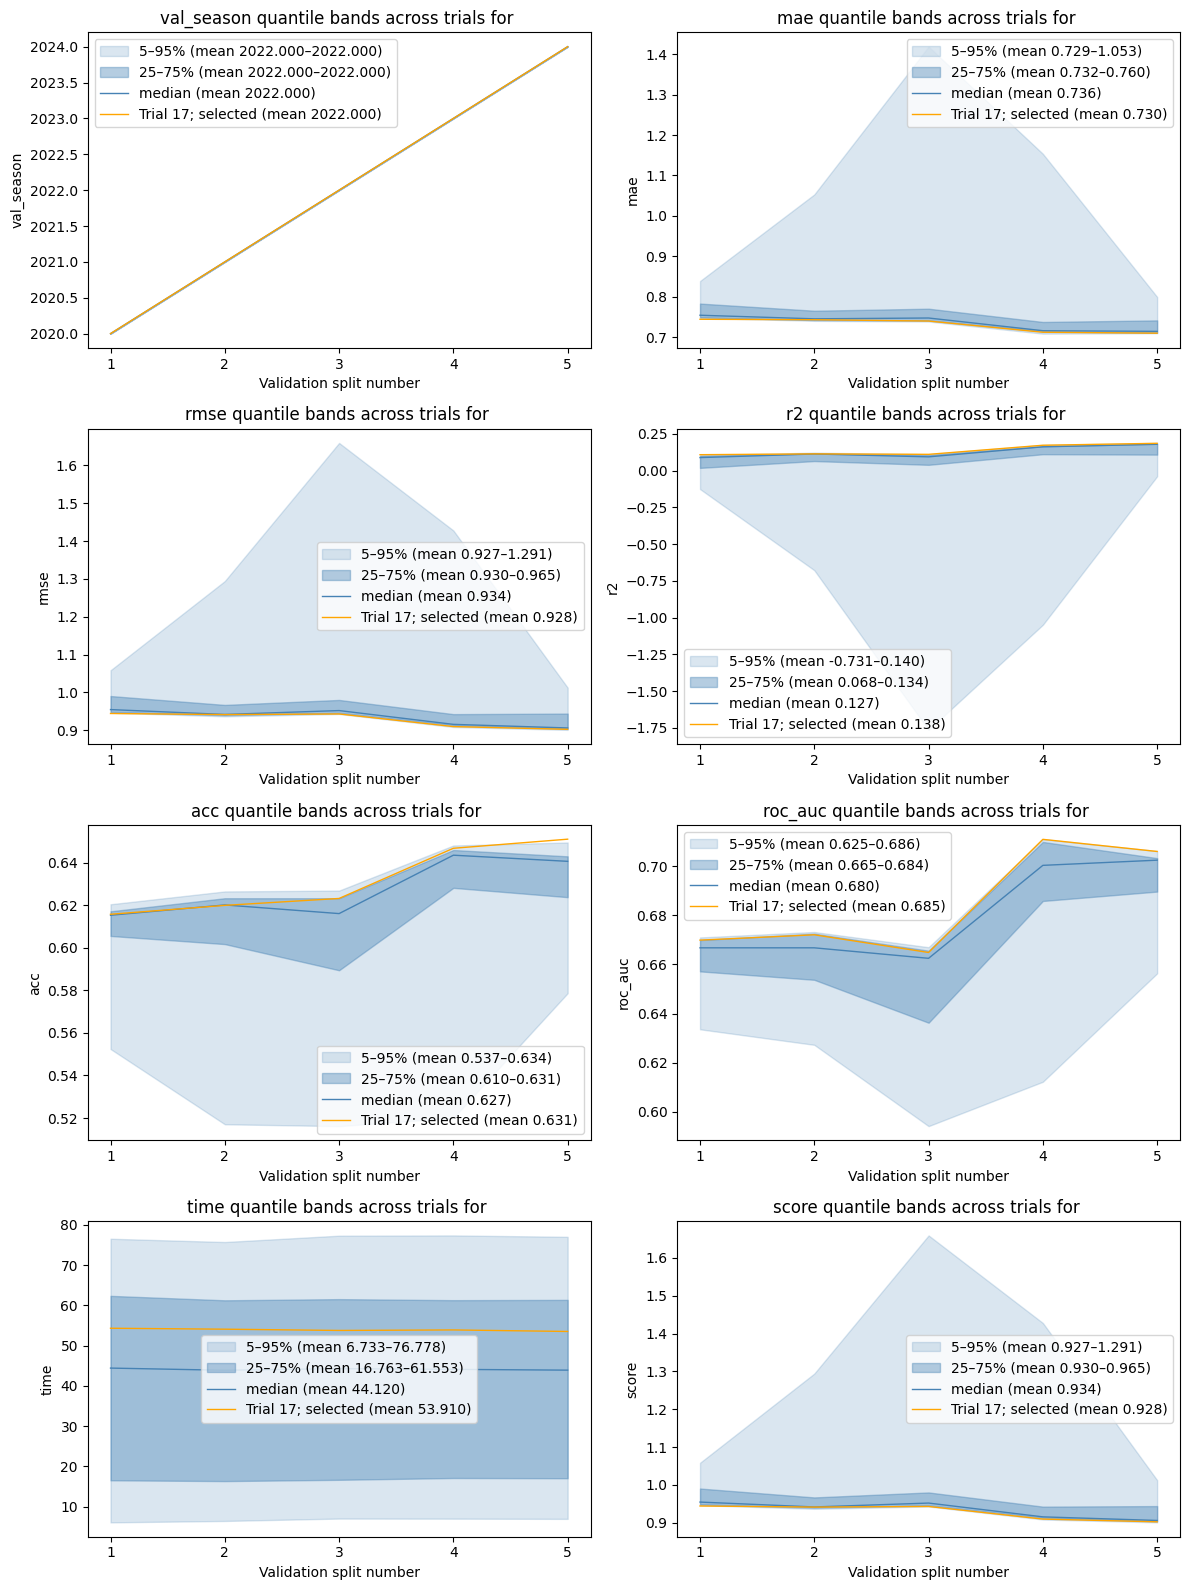

In [ ]:
import optuna
import optuna.visualization as vis

# Load study into memory
torch_ffnn_study = optuna.load_study(
    study_name="torch_ffnn_study",
    storage="sqlite:///optuna_studies.db"
)

# Visualize the study
vis.plot_optimization_history(torch_ffnn_study).show()
vis.plot_parallel_coordinate(torch_ffnn_study).show()
vis.plot_param_importances(torch_ffnn_study).show()
vis.plot_slice(torch_ffnn_study).show()

get_metric_quantiles_fig(torch_ffnn_study).show()

In [ ]:
!ls models

baseline_0_model.joblib  lasso_model.joblib  torch_ffnn_weights.pth
baseline_1_model.joblib  lgbm_model.joblib


In [ ]:
# For training torch_ffnn
if CONTROL_FLOW['train_models']:
    modeling_config = "torch_ffnn.py"
    model_filename = "torch_ffnn_weights.pth"

    # Train the tuned lasso model, save
    kwargs = {"--modeling_config" : modeling_config}
    run_script("scripts/train_model.py", kwargs)

if CONTROL_FLOW['save_models']:

    source_file = Path(config["model_storage"]) / model_filename
    dest_file = Path(STORAGE_PATH) / config['model_storage'] / model_filename
    print(source_file)
    print(dest_file)
    if source_file.exists():
        # Make sure the destination folder exists
        dest_file.parent.mkdir(parents=True, exist_ok=True)

        # Copy the file
        shutil.copy2(source_file, dest_file)
        print(f"Copied {source_file} to {dest_file}")
    else:
        print("Data to load not found")


Best hyperparams of '<class 'config.FFNN'>' from 'torch_ffnn_study':
FrozenTrial(number=17, state=1, values=[0.9282195669846741], datetime_start=datetime.datetime(2025, 10, 7, 14, 21, 23, 122238), datetime_complete=datetime.datetime(2025, 10, 7, 14, 25, 52, 759736), params={'n_hidden_layers': 2, 'n_train_seasons': 7, 'lr': 0.0043430212005031, 'n_epochs': 3}, user_attrs={'metrics': {'val_season': [2020, 2021, 2022, 2023, 2024], 'mae': [0.7445850523904003, 0.7434676671680425, 0.7401927886617192, 0.7125340175781533, 0.7101948245419597], 'rmse': [0.9443356030451162, 0.9414309329035092, 0.9431042837881183, 0.9097445226650832, 0.9024824925215431], 'r2': [0.10781722123865689, 0.11334737067432854, 0.1101925995751245, 0.17202832963113657, 0.18519277631508868], 'acc': [0.6157407407407407, 0.6199186991869918, 0.6231707317073171, 0.6467479674796748, 0.6510204081632653], 'roc_auc': [0.6698799725651577, 0.6720430960407164, 0.6648502875272655, 0.7109022407297244, 0.7059658475635153], 'time': [54.3098

In [ ]:
run_script("scripts/check_studies.py")

Existing studies at 'sqlite:///optuna_studies.db':

 #### baseline_0_study ####
 * Number of trials: 1
 * Best trial number: 0
 * Best trial value: 1.000
 * Metrics:
Split      | 1          | 2          | 3          | 4          | 5          | Mean      
-------------------------------------------------------------------------------------------
val_season | 2020-21    | 2021-22    | 2022-23    | 2023-24    | 2024-25    | -         
mae        | 0.801      | 0.803      | 0.805      | 0.797      | 0.798      | 0.801     
rmse       | 1.000      | 1.000      | 1.000      | 1.000      | 1.000      | 1.000     
r2         | 0.000      | 0.000      | 0.000      | 0.000      | 0.000      | 0.000     
acc        | 0.500      | 0.500      | 0.500      | 0.500      | 0.500      | 0.500     
roc_auc    | 0.500      | 0.500      | 0.500      | 0.500      | 0.500      | 0.500     
time       | 0.010      | 0.006      | 0.006      | 0.006      | 0.006      | 0.007     
score      | 1.000      | 1.00

There are some useful takeaways from the above plots that can be deduced for this linear regression model that uses rolling average (note that mean and standard deviation refer to the **target distribution**):
* The model's output somewhat mirrors the target distribution, containing a 'double hump' outline
* The model tends to make more conservative estimates, almost all falling within a standard deviation of the target distribution
* Since the model learned to make conservative predictions, it is penalized heavily when the target is more than a standard deviation from the mean

All in all, this is a model that, with respect to a given game, takes in only 3 inputs and generates a respectable guess, far better than the baseline.  Furthermore, it better mirrors the target distribution, unlike the random forest regressor.

However, can the linear regression be improved upon? While a better fit for the problem of predicting the score of a game than tree-based methods, the model still rather simple and doesn't fully leverage relevant data effectively. After all, in taking rolling averages of previous games, *information is lost about the specific stats included in the games themselves.* Can each game be considered individually, as its own separate entity, in generating predictions, and can this improve performance? In the sections that follow, this question is explored in more detail.

# (5) Summary + Conclusion

To recount everything this notebook encompassed:


1.   Data was read in from an external source
2.   Data was cleaned, made easier to work with
3.   Exploratory Data Analysis is performed with visualizations of the data
4.   Typical statistical models using selected features were used to successfully predict the outcome of NBA games
5.  Stronger, attention-based models, including a transformer with a learned attention mechanism, were built and trained on the data, performing at least as well as the statistical models

To briefly highlight some interesting/significant results along the way:
* Plus-minus's dual-peak distribution
* Home-team advantage's significant predictivity is in game outcome
* Increasing the lookback window give rolling averages that correlate more with game outcome
* A fixed-attention sequential model can be used to make predictions as well as well as statistical models using rolling averages
* A transformer model can successfully learn which games to attend to when making predictions, and perform as well as any other model

## Shortcomings + what's next

This project is somewhat significant in-and-of itself, as no transformer-based model exists online for the task of predicting the outcome of a yet-to-be-played game using previous stats. However, there is still room for a lot more work to be done, and there are many directions to further explore relating to this project. Some of these areas of improvement include:
* Extracting more NBA data from external sources (such as the NBA-API) and incorporating it into some version of the workflow demonstrated throughout this notebook
* Conducting more thorough in training experiments than were shown in this notebook, e.g. utilizing different train-val-test splits, hyperparameter tuning, optimization methods, stopping conditions, etc.
* Performing more rigorous in analysis analysis of experimental results and model performance; e.g. how well it performs on each season, statistical significance of results, etc.
* Building stronger transformer architectures that can better learn to leverage all of the information it is given optimally
* Addressing any additional bias in experiments, such as PyTorch setup currently only learns from games from the home-team's perspective
* Better streamlining some version the workflow above

In general, attention-based transformer NN architectures have been proven to be extremely strong and expressive, and they have taken over many fields AI, using different types of data to perform many different tasks. Furthermore, scaling laws show that *giving transformers enough compute, data, and size only improves them, and does so predictably*. Using them to predict the outcome of sports games, on some level, can seem somewhat insignificant and inconsequential. However, the idea of learning how to fully harness a transformer's potential to accurately predict future events is one that cannot be overlooked or understated.